Lambda School Data Science

*Unit 2, Sprint 2, Module 2*

---

In [27]:
!pip install category_encoders==2.*
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.impute import KNNImputer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Module Project: Random Forests

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump datset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account.
- **Task 2:** Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_dt`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` to reduce overfitting.
- **Task 9 `stretch goal`:** Create a horizontal bar chart showing the 10 most important features for your model.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `sklearn`

# I. Wrangle Data

In [65]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    
    # Drop constant columns
    df.drop(columns=['recorded_by','num_private'], inplace=True)
    
    # Create age feature
    df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
    df.drop(columns=['date_recorded','construction_year'], inplace=True)
    
    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)             


    return df

df = wrangle(fm_path= 'train_features.csv',
             tv_path= 'train_labels.csv')

X_test = wrangle(fm_path= 'test_features.csv')

**Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account. Choose a username that's based on your real name. Like GitHub, Kaggle is part of your public profile as a data scientist.

**Task 2:** Modify the `wrangle` function to engineer a `'pump_age'` feature. Then use the function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [66]:
target = 'status_group'
y = df[target]
X = df.drop(columns=target)

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [67]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=42)

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [68]:
baseline_Acc = y_train.value_counts(normalize=True).max()
print('Baseline accuracy:',baseline_Acc)

Baseline accuracy: 0.5425489938182296


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_rf`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `RandomForestClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `RandomForestClassifier`. Also, to decrease training time, set `n_jobs` to `-1`.

In [69]:
# # Important parameters to tune for RF: n_estimators, max_samples, max_depth, max_features
# model_rf = make_pipeline(OrdinalEncoder(),
#                          SimpleImputer(),  #Try using KNN Imputer
#                          RandomForestClassifier(n_jobs = -1,
#                                                 random_state=42, 
#                                                 n_estimators = 270,
#                                                 max_samples = 0.8,
#                                                 max_features=12,
#                                                class_weight='balanced_subsample',
#                                                max_depth=35))
# model_rf.fit(X_train,y_train)

In [70]:
model_rf = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy='mean'),
                         RandomForestClassifier(n_jobs=-1,
                                                random_state=42,
                                                max_depth=25,
                                                max_samples=.5,
                                                n_estimators=180,
                                                max_features='sqrt',
                                                ))

model_rf.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type'],
                                mapping=[{'col': 'basin',
                                          'data_typ...
dtype: int64},
                                         {'col': 'waterpoint_type',
                                          'data_type': dtype('O'),
                                          'mapping': hand pump                  

In [71]:
# # Important parameters to tune for RF: n_estimators, max_samples, max_depth, max_features
# model_rf = make_pipeline(OrdinalEncoder(),
#                          SimpleImputer(),  #Try using KNN Imputer
#                          RandomForestClassifier(n_jobs = -1,))
# model_rf.fit(X_train,y_train)

# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_rf`.

In [100]:
training_acc = accuracy_score(y_train,model_rf.predict(X_train))
val_acc = accuracy_score(y_val,model_rf.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9439694857293174
Validation Accuracy Score: 0.8049242424242424


# VI. Tune Model

**Task 8:** Tune `n_estimators` and `max_depth` hyperparameters for your `RandomForestClassifier` to get the best validation accuracy score for `model_rf`.

In [119]:
min_impurity_decreases = np.arange(0, 30, 1)
train_acc = []
val_acc = []

for min_impurity_decrease_ in min_impurity_decreases:
    treetree= make_pipeline(OrdinalEncoder(),
                            SimpleImputer(strategy='mean'),
                            RandomForestClassifier(n_jobs=-1,
                                                   random_state=42,
                                                   max_depth=25,
                                                   max_samples=.5,
                                                   n_estimators=180,
                                                   max_features='sqrt',
                                                   criterion='entropy',
                                                   min_impurity_decrease=min_impurity_decrease_,
                                                   class_weight=None))
    
    treetree.fit(X_train, y_train)
    train_acc.append(treetree.score(X_train, y_train))
    val_acc.append(treetree.score(X_val, y_val))

In [118]:
val_acc

[0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135]

In [81]:
X_train.shape

(38015, 26)

In [82]:
y_train.shape

(38015,)

In [23]:
max_features = list(range(1,X_train.shape[1]))
train_results = []
test_results = []

for max_feature in max_features:
    treetree= make_pipeline(OrdinalEncoder(),
                            SimpleImputer(strategy='mean'),
                            RandomForestClassifier(n_jobs=-1,
                                                   random_state=42,
                                                   max_depth=25,
                                                   max_samples=.5,
                                                   n_estimators=95,
                                                   max_features=max_feature))
    
    treetree.fit(X_train, y_train)
    train_acc.append(treetree.score(X_train, y_train))
    val_acc.append(treetree.score(X_val, y_val))

In [26]:
val_acc

[0.6037457912457912,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.5447180134680135,
 0.7980850168350169,
 0.8003998316498316,
 0.8009259259259259,
 0.804503367003367,
 0.8016624579124579,
 0.8011363636363636,
 0.8003998316498316,
 0.7991372053872053,
 0.8016624579124579,
 0.7997685185185185,
 0.8015572390572391,
 0.8002946127946128,
 0.8012415824915825,
 0.8019781144781145,
 0.8011363636363636,
 0.8013468013468014,
 0.8009259259259259,
 0.8005050505050505,
 0.8006102693602694,
 0.7980850168350169,
 0.8010311447811448,
 0.8011363636363636,
 0.8008207070707071,
 0.8011363636363636,
 0.8003998316498316,
 0.7996632996632996]

In [25]:
plt.plot(depths, train_acc, color='blue', label='training')
plt.plot(depths, val_acc, color='red', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

NameError: name 'depths' is not defined

In [24]:
sns.set(rc={'figure.figsize':(15,10)})

# Depth -

In [13]:
depths = range(17, 30, 1)
train_acc = []
val_acc = []

for depth in depths:

  tree_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy='mean'),
      RandomForestClassifier(max_depth=depth,
                             random_state=42,
                             n_jobs=-1))

  tree_model.fit(X_train, y_train)
  train_acc.append(tree_model.score(X_train, y_train))
  val_acc.append(tree_model.score(X_val, y_val))

In [14]:
val_acc

[0.7993476430976431,
 0.7981902356902357,
 0.7985058922558923,
 0.7995580808080808,
 0.8017676767676768,
 0.8006102693602694,
 0.7980850168350169,
 0.7991372053872053,
 0.7986111111111112,
 0.79503367003367,
 0.7962962962962963,
 0.7951388888888888,
 0.7938762626262627]

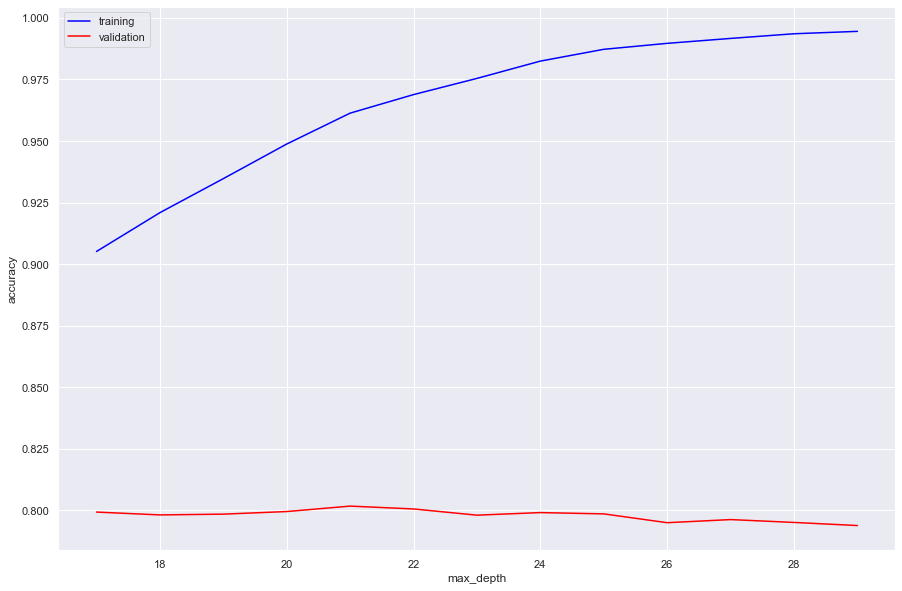

In [15]:
plt.plot(depths, train_acc, color='blue', label='training')
plt.plot(depths, val_acc, color='red', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Sample Vs Depth -

In [16]:
# Tune RF for max_samples
samples = np.arange(0.2,1,0.1)

train_acc = []
val_acc = []
for sample in samples:
  model_rf1 = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy='mean'),
                         RandomForestClassifier(n_jobs = -1,
                                                random_state=42,
                                                max_depth = 21,
                                                max_samples = sample))
  model_rf1.fit(X_train,y_train)
  train_acc.append(model_rf1.score(X_train,y_train))
  val_acc.append(model_rf1.score(X_val,y_val))

In [17]:
val_acc

[0.7929292929292929,
 0.7982954545454546,
 0.7994528619528619,
 0.8008207070707071,
 0.8012415824915825,
 0.8018728956228957,
 0.8021885521885522,
 0.8000841750841751]

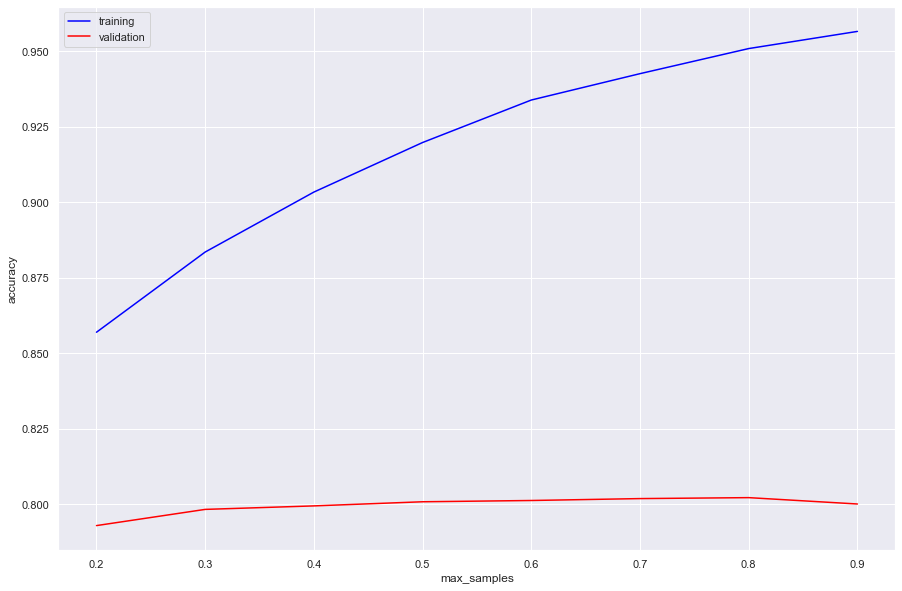

In [18]:
plt.plot(samples, train_acc, color='blue', label='training')
plt.plot(samples, val_acc, color='red', label='validation')
plt.xlabel('max_samples')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Estimate vs Depth -

In [24]:
estimates = range(175, 220, 5)
train_acc = []
val_acc = []

for estiamte in estimates:
  model_rf1 = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy='mean'),  #Try using KNN Imputer
                         RandomForestClassifier(n_jobs = -1,
                                                random_state=42,
                                                max_depth = 21,
                                                n_estimators = estiamte))

  model_rf1.fit(X_train,y_train)
  train_acc.append(model_rf1.score(X_train,y_train))
  val_acc.append(model_rf1.score(X_val,y_val))

In [25]:
val_acc

[0.8009259259259259,
 0.8007154882154882,
 0.8005050505050505,
 0.8007154882154882,
 0.8005050505050505,
 0.8006102693602694,
 0.8008207070707071,
 0.8000841750841751,
 0.7997685185185185]

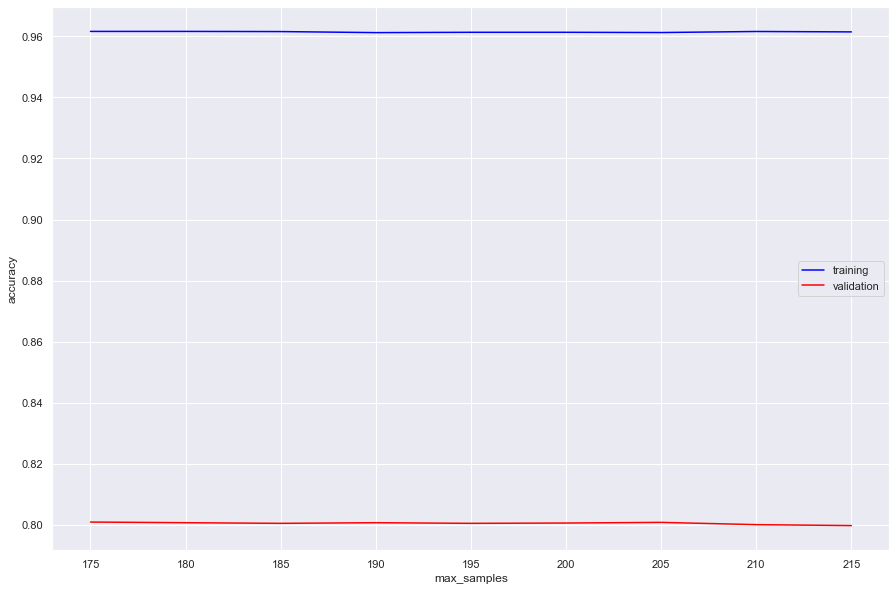

In [27]:
plt.plot(estimates, train_acc, color='blue', label='training')
plt.plot(estimates, val_acc, color='red', label='validation')
plt.xlabel('max_samples')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Max sample vs Estimate & Depth

In [30]:
# Tune RF for max_samples
samples = np.arange(0.2,1,0.1)

train_acc = []
val_acc = []
for sample in samples:
  model_rf1 = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy='mean'),
                         RandomForestClassifier(n_jobs = -1,
                                                random_state=42,
                                                max_depth = 21,
                                                n_estimators=175,
                                                max_samples = sample))
  model_rf1.fit(X_train,y_train)
  train_acc.append(model_rf1.score(X_train,y_train))
  val_acc.append(model_rf1.score(X_val,y_val))

In [31]:
val_acc

[0.7966119528619529,
 0.7989267676767676,
 0.8008207070707071,
 0.8017676767676768,
 0.8032407407407407,
 0.8036616161616161,
 0.803030303030303,
 0.8007154882154882]

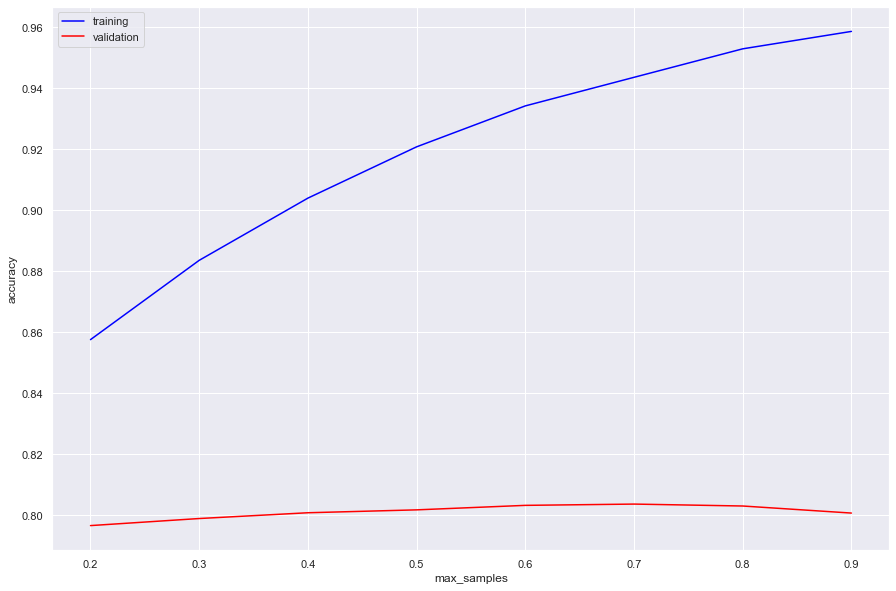

In [32]:
plt.plot(samples, train_acc, color='blue', label='training')
plt.plot(samples, val_acc, color='red', label='validation')
plt.xlabel('max_samples')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Estiamte vs Max Sample & Depth -

In [19]:
estimates = range(175, 220, 5)
train_acc = []
val_acc = []

for estiamte in estimates:
  model_rf1 = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy='mean'),  #Try using KNN Imputer
                         RandomForestClassifier(n_jobs = -1,
                                                random_state=42,
                                                max_depth = 21,
                                                max_samples = .8,
                                                n_estimators = estiamte))

  model_rf1.fit(X_train,y_train)
  train_acc.append(model_rf1.score(X_train,y_train))
  val_acc.append(model_rf1.score(X_val,y_val))

In [20]:
val_acc

[0.803030303030303,
 0.8040824915824916,
 0.80239898989899,
 0.8018728956228957,
 0.8017676767676768,
 0.8025042087542088,
 0.8026094276094277,
 0.8022937710437711,
 0.8020833333333334]

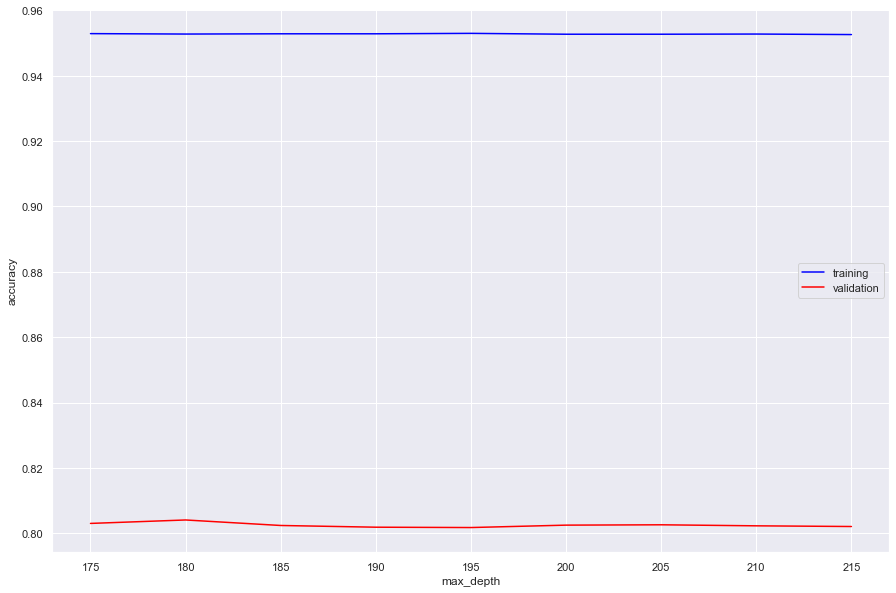

In [21]:
plt.plot(estimates, train_acc, color='blue', label='training')
plt.plot(estimates, val_acc, color='red', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Feature Importance -

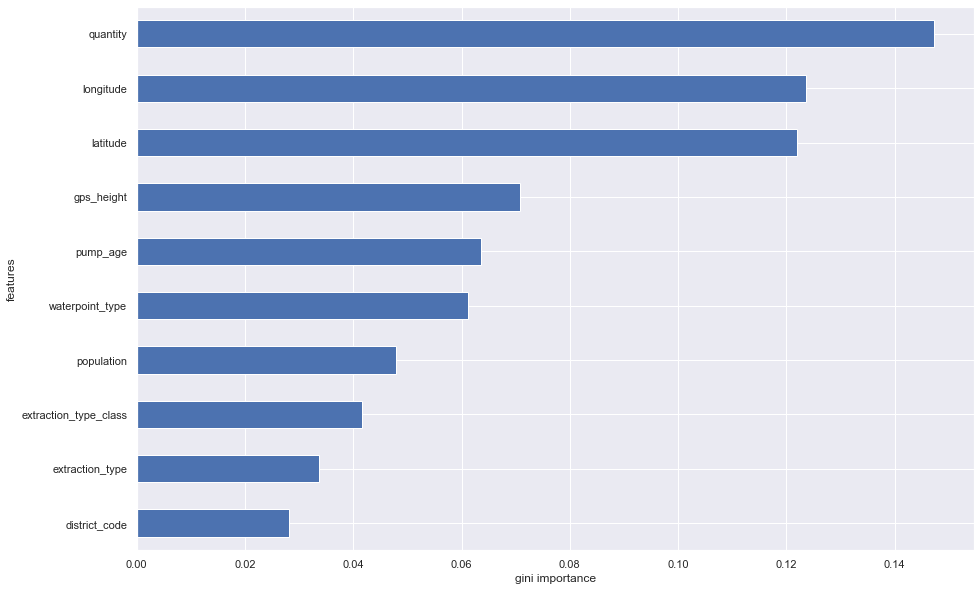

In [22]:
features = model_rf.named_steps['ordinalencoder'].get_feature_names()
gini = model_rf.named_steps['randomforestclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

# VII. Communicate Results

**Task 9:** Generate a list of predictions for `X_test`. The list should be named `y_pred`.

In [23]:
assert len(y_pred) == len(X_test), f'Your list of predictions should have {len(X_test)} items in it. '

NameError: name 'y_pred' is not defined

**Task 11 `stretch goal`:** Create a DataFrame `submission` whose index is the same as `X_test` and that has one column `'status_group'` with your predictions. Next, save this DataFrame as a CSV file and upload your submissions to our competition site. 

**Note:** Check the `sample_submission.csv` file on the competition website to make sure your submissions follows the same formatting. 

In [ ]:
X_test

In [ ]:
X_test = X_test[X_train.columns]
# Predict X_test and use the ids from the test data
submission = pd.DataFrame(data=model_rf.predict(X_test), index=X_test.index)
# Rename column to be status_group because that is the submission format
submission.columns = ['status_group']
submission.head()

In [ ]:
# generate CSV
submission = submission.to_csv('newest_submission.csv')

In [ ]:
# download
from google.colab import files
files.download("newest_submission.csv")